## Decision Trees

In [49]:
import pandas as pd
import numpy as np

import scipy.stats as stats
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
# from xgboost import XGBClassifier

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

from numeric import get_numeric_df

In [4]:
original_df = pd.read_csv("..\\Dataset\\preprocessed_data\\fraud_oracle_preprocessed_drop.csv")
df = get_numeric_df(original_df)
df.head()

,Month,WeekOfMonth,DayOfWeek,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,Age,Fault,...,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,VehicleCategory_Sedan,VehicleCategory_Sport,VehicleCategory_Utility,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability
0,11,5,2,0,1,0,1,0,21.0,1,...,0,0,1,0,0,1,0,0,0,1
1,0,3,2,0,0,0,4,1,34.0,1,...,0,0,1,0,0,1,0,0,1,0
2,9,5,4,0,3,10,2,1,47.0,1,...,0,1,0,0,0,1,0,0,1,0
3,5,2,5,0,4,6,1,1,65.0,0,...,0,1,0,0,0,1,0,0,0,1
4,0,5,0,0,1,1,2,0,27.0,0,...,0,0,1,0,0,1,0,0,1,0


In [42]:
def get_stats(classifier, X, Y, k = 10):
    out = dict()
    res = cross_validate(clf_DTmodel, X, Y, cv=k, scoring=['accuracy', 'balanced_accuracy', 'precision','recall', 'roc_auc'])
    for score in res:
        out[score] = np.mean(res[score])
    return out


In [43]:
# X, Y -> explanatory/resopnse variable split
X = df.drop('FraudFound_P',axis=1).copy()
Y = df['FraudFound_P'].copy()

### Basic Decision Tree

fit_time: 0.10142304897308349
score_time: 0.010575079917907714
test_accuracy: 0.8944814920491435
test_balanced_accuracy: 0.537118593928842
test_precision: 0.1286322804969547
test_recall: 0.13114773258532023
test_roc_auc: 0.5371185939288421


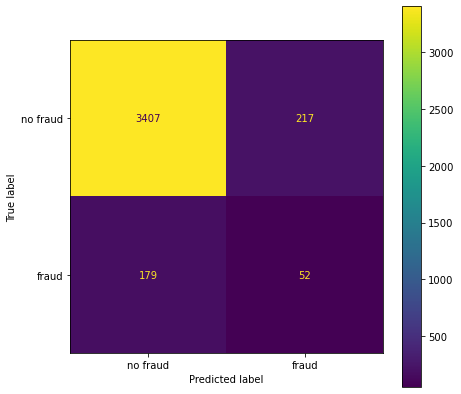

In [45]:
# Basic DT
clf_DTmodel = DecisionTreeClassifier(random_state=0)
results = get_stats(clf_DTmodel, X, Y)
for r in results:
    print(f'{r}: {results[r]}')


x_train,x_test,y_train,y_test = train_test_split(X, Y, stratify=Y,random_state=0)
clf_DTmodel.fit(x_train,y_train)
y_pred_gini_unpruned = clf_DTmodel.predict(x_test)

fig, (ax1) = plt.subplots(figsize=(7, 7))
metrics.plot_confusion_matrix(clf_DTmodel, x_test, y_test, display_labels=["no fraud", "fraud"], ax=ax1)

In [48]:
# Compare different pruning levels
# ccp_alphas = [0.2, 0.4, 0.5, 0.8]
# for a in ccp_alphas:
#     print(f'CCP alpha: {a}')
#     results = get_stats(clf_DTmodel, X, Y)
#     for r in results:
#         print(f'{r}: {results[r]}')
#     print()

### Other classifiers

In [51]:
classifiers = {
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
}

In [54]:
# trash :((
df_models = pd.DataFrame(columns = ['model', 
                                    'avg_accy',
                                    'avg_accy_std',  
                                    'avg_recall',
                                    'avg_recall_std',
                                    'avg_precision',
                                    'avg_precision_std',
                                    'avg_roc_auc',
                                    'avg_roc_auc_std', 
                                     ])


scorer = {'accuracy_score':metrics.make_scorer(metrics.accuracy_score),
          'f1_score':metrics.make_scorer(metrics.f1_score),
          'recall_score':metrics.make_scorer(metrics.recall_score),
          'precision_score':metrics.make_scorer(metrics.average_precision_score),
          'matthew_corrcoef':metrics.make_scorer(metrics.matthews_corrcoef),
          'roc_auc_score':metrics.make_scorer(metrics.roc_auc_score) 
         }

for key in classifiers:
    print('*', key)
    classifier = classifiers[key]
    model = classifier.fit(x_train,y_train)
    cvs = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    cv_scores = cross_validate(model, x_test, y_test, cv=cvs, scoring = scorer)
    y_pred = model.predict(x_test)
    
    row = {
        'model': key,
        'avg_accy': cv_scores['test_accuracy_score'].mean(),
        'avg_accy_std': cv_scores['test_accuracy_score'].std(),
        'avg_recall': cv_scores['test_recall_score'].mean(),
        'avg_recall_std': cv_scores['test_recall_score'].std(),
        'avg_precision': cv_scores['test_precision_score'].mean(),
        'avg_precision_std': cv_scores['test_precision_score'].std(),
        'avg_roc_auc': cv_scores['test_roc_auc_score'].mean(),
        'avg_roc_auc_std': cv_scores['test_roc_auc_score'].std(),
    }
    
    df_models = df_models.append(row, ignore_index=True)

In [53]:
df_models.head()

,model,avg_accy,avg_accy_std,avg_recall,avg_recall_std,avg_precision,avg_precision_std,avg_roc_auc,avg_roc_auc_std
0,DecisionTreeClassifier,0.893556,0.011971,0.221981,0.074068,0.091417,0.022704,0.579166,0.037353
1,RandomForestClassifier,0.939991,0.000869,0.0,0.0,0.059922,0.000755,0.499954,0.000248
2,AdaBoostClassifier,0.935839,0.003868,0.017331,0.026508,0.065666,0.011357,0.505859,0.013048
